# Data integration

Si vogliono integrare i 3 dataset: CEDAR, ICAR2011 e Kaggle

L'approccio di mettere tutto in un unico calderone e poi splittare in train e test però non è valido in quanto potrebbero capitare delle suddivisioni particolarmente sfortunate nel quale molte firme di un unico soggetto ricadono nel test, e di conseguenza il modello non viene trainato a dovere. Il train e il test set devono quindi essere preparati su misura per questo problema.

Il metodo che segue consiste, in primo luogo, nel assegnare degli id che identificano univocamente il soggetto a cui è riferita la firma, e in secondo luogo, un flag per distinguere se la firma è originale o contraffatta. Questo permette di avere un dataset pronto per due usi: 

*   Signature identification -> Capire a chi è riferita la firma
*   Signature verification   -> Verificare che la firma sia autentica

Successivamente si divide il dataset in train e test in modo tale da essere certi che per ogni soggetto ci siano firme autentiche e contraffatte nel test set.





In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
import os
import shutil
from tqdm import tqdm
from PIL import Image
import re
import random

In [ ]:
# Mount del disco da google drive
drive.mount("/content/gdrive", force_remount=True)

root_dir = "/content/gdrive/MyDrive"
base_dir = os.path.join(root_dir, "SigNature", "Datasets")

Mounted at /content/gdrive


In [ ]:
# Path dei datasets da integrare
KAGGLE_dataset = os.path.join(base_dir, "Kaggle", "Dataset_Signature_Final", "Dataset")
CEDAR_dataset = os.path.join(base_dir, "CEDAR")
ICDAR2011_dataset = os.path.join(base_dir, "ICDAR2011_clean")

# Path del dataset integrato
INTEGRATED_dataset = os.path.join(base_dir, "SigNature_integration")

In [ ]:
# Rimuove precedenti salvataggi
try: 
    shutil.rmtree(INTEGRATED_dataset)
except OSError as error: 
    print(error)  

In [ ]:
# Crea la dir nel quale salvare il nuovo dataset
try: 
    os.mkdir(INTEGRATED_dataset)
except OSError as error: 
    print(error)

In [ ]:
oldId_newId = {} # Contiene il mapping tra vecchi id e quelli nuovi
newId_count = {} # Contine il count delle immagini per persona [n_forged, n_genuine]

offset = 0 # Utile per la generazione degli id a partire da un nuovo dataset

## Utility

In [ ]:
original_shapes = []
low_quality_ids = set()

In [ ]:
def create_id(img_old_id):
  if img_old_id not in oldId_newId:
     # Crea un nuovo identificativo se il vecchio id non esiste nel mapping
    if not bool(newId_count.keys()):
      new_id = 1
    else:
      new_id = 1 + max(newId_count.keys())
    oldId_newId[img_old_id] = new_id
  return oldId_newId[img_old_id]

In [ ]:
def update_counter(new_id, is_forged): # Aggiorna il contatore delle immagini
  if new_id in newId_count:
    if is_forged:
      newId_count[new_id][0] = 1 + newId_count[new_id][0] 
    else: 
      newId_count[new_id][1] = 1 + newId_count[new_id][1]
  else: 
    if is_forged:
      newId_count[new_id] = [1, 0] # [n_forged, n_real]
    else:
      newId_count[new_id] = [0, 1] # [n_forged, n_real]

In [ ]:
def create_folder(new_id, is_forged):
  if is_forged:
    folder_name = str(new_id) + "_forged"
  else: folder_name = str(new_id) + "_genuine"

  try: os.mkdir(os.path.join(INTEGRATED_dataset, folder_name))
  except: None

  return folder_name

In [ ]:
def save_img(img_obj, folder_name, is_forged, new_type, new_id):
  if is_forged:
    path = os.path.join(INTEGRATED_dataset, folder_name,
                        str(newId_count[new_id][0]) + ".png")
  else:
    path = os.path.join(INTEGRATED_dataset, folder_name,
                        str(newId_count[new_id][1]) + ".png")
    
  cv2.imwrite(path, img_obj)

In [ ]:
def img_preprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Greyscale
  #img = cv2.GaussianBlur(img, (5,5), 0) # Gaussian blur
  img[ img > 230 ] = 255
  #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Threshold
  img = cv2.bitwise_not(img) # Invert
  original_shapes.append(img.shape)
  img = cv2.resize(img, (256, 128), interpolation = cv2.INTER_LINEAR)
  return img

In [ ]:
def load_preprocess(img_path, new_id):
  img = cv2.imread(img_path)
  if img.shape[0] < 128 or img.shape[1] < 256: # height, width
    low_quality_ids.add(new_id)
  img = img_preprocess(img)
  return img

In [ ]:
def integration_pipe(old_id, img_path, is_forged, new_type = "png"):
  new_id = create_id(old_id + offset)
  update_counter(new_id, is_forged)
  img_obj = load_preprocess(img_path, new_id)
  folder_name = create_folder(new_id, is_forged)
  save_img(img_obj, folder_name, is_forged, new_type, new_id)

## Integrazione del dataset KAGGLE

Contains Genuine and Forged signatures of 30 people. 
Each person has 5 Genuine signatures which they made themselves and 5 Forged signatures someone else made.
* 00602023 is an image of signature of person number 023 done by person 006. This is a forged signature. 
* 02103021 is an image of signature of person number 021 done by person 021. This is a genuine signature.

Link: https://www.kaggle.com/divyanshrai/handwritten-signatures

In [ ]:
def add_from_dir(data_dir):
  for img_name in tqdm(os.listdir(data_dir + "/forge")):
    img_path = os.path.join(data_dir + "/forge", img_name)
    old_id = int(img_name[5:8])
    integration_pipe(old_id, img_path, is_forged = True)

  for img_name in tqdm(os.listdir(data_dir + "/real")):
    img_path = os.path.join(data_dir + "/real", img_name)
    old_id = int(img_name[5:8])
    integration_pipe(old_id, img_path, is_forged = False)

In [ ]:
add_from_dir(os.path.join(KAGGLE_dataset, "dataset1"))
add_from_dir(os.path.join(KAGGLE_dataset, "dataset2"))

# Il dataset contiene moltre altre immagini che si riferiscono alle stesse persone 
# ma gli id non sono consistenti. Non si possono quindi integrare a meno che non
# si confronti ogni firma manualmente

#add_from_dir(os.path.join(KAGGLE_dataset, "dataset3"))
#add_from_dir(os.path.join(KAGGLE_dataset, "dataset4"))

100%|██████████| 60/60 [00:01<00:00, 31.00it/s]


## Integrazione del dataset CEDAR

There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers).

Link: https://paperswithcode.com/dataset/cedar-signature

In [ ]:
offset = max(oldId_newId.keys())

In [ ]:
def add_from_dir(data_dir):
  for img_name in tqdm(os.listdir(data_dir + "/full_forg")):
    img_path = os.path.join(data_dir + "/full_forg", img_name)
    old_id, _ = map(int, re.findall('\d+', img_name))
    integration_pipe(old_id, img_path, is_forged = True)

  for img_name in tqdm(os.listdir(data_dir + "/full_org")):
    img_path = os.path.join(data_dir + "/full_org", img_name)
    old_id, _ = map(int, re.findall('\d+', img_name))
    integration_pipe(old_id, img_path, is_forged = False)

In [ ]:
add_from_dir(CEDAR_dataset)

100%|██████████| 1320/1320 [00:29<00:00, 44.98it/s]


## Integrazione del dataset ICDAR2011 (Dutch)

signatures of 10 reference writers and skilled forgeries of these signatures.
total offline: 362 signatures.




Link: http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2011_Signature_Verification_Competition_(SigComp2011)

In [ ]:
offset = max(oldId_newId.keys())

In [ ]:
def add_from_dir(data_dir):
  for folder in tqdm(os.listdir(data_dir)):
    is_forged = True if "forg" in folder else False
    old_id = int(re.findall('\d+', folder)[0])
    for img_name in os.listdir(os.path.join(data_dir, folder)):
      img_path = os.path.join(data_dir, folder, img_name)
      integration_pipe(old_id, img_path, is_forged)

In [ ]:
add_from_dir(ICDAR2011_dataset + "/train")
add_from_dir(ICDAR2011_dataset + "/test")

100%|██████████| 42/42 [00:11<00:00,  3.81it/s]


## Rimozione ids con immagini di scarsa qualità e conserva solo id che hanno tutte le immagini con dimensione almeno superiore a 128 x 256

In [ ]:
print("Id da rimuovere: ", len(low_quality_ids))
print(low_quality_ids)

Id da rimuovere:  22
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 130, 70, 79, 80, 84, 111, 118, 122, 124, 127}


In [ ]:
# nuovo remapping
old_ids = set(newId_count.keys())
differences = old_ids.difference(low_quality_ids)
new_remapping = {}

for i, j in enumerate(differences, 1):
  new_remapping[j] = i

In [ ]:
# Elimina le cartelle low quality
for id in low_quality_ids:
  folder_g = str(id) + "_genuine"
  folder_f = str(id) + "_forged"
  try: 
    shutil.rmtree(INTEGRATED_dataset + "/" + folder_g)
    shutil.rmtree(INTEGRATED_dataset + "/" + folder_f)
  except OSError as error: 
    print(error)  

In [ ]:
print(new_remapping)

{13: 1, 14: 2, 15: 3, 16: 4, 17: 5, 18: 6, 19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 29: 17, 30: 18, 31: 19, 32: 20, 33: 21, 34: 22, 35: 23, 36: 24, 37: 25, 38: 26, 39: 27, 40: 28, 41: 29, 42: 30, 43: 31, 44: 32, 45: 33, 46: 34, 47: 35, 48: 36, 49: 37, 50: 38, 51: 39, 52: 40, 53: 41, 54: 42, 55: 43, 56: 44, 57: 45, 58: 46, 59: 47, 60: 48, 61: 49, 62: 50, 63: 51, 64: 52, 65: 53, 66: 54, 67: 55, 68: 56, 69: 57, 71: 58, 72: 59, 73: 60, 74: 61, 75: 62, 76: 63, 77: 64, 78: 65, 81: 66, 82: 67, 83: 68, 85: 69, 86: 70, 87: 71, 88: 72, 89: 73, 90: 74, 91: 75, 92: 76, 93: 77, 94: 78, 95: 79, 96: 80, 97: 81, 98: 82, 99: 83, 100: 84, 101: 85, 102: 86, 103: 87, 104: 88, 105: 89, 106: 90, 107: 91, 108: 92, 109: 93, 110: 94, 112: 95, 113: 96, 114: 97, 115: 98, 116: 99, 117: 100, 119: 101, 120: 102, 121: 103, 123: 104, 125: 105, 126: 106, 128: 107, 129: 108, 131: 109}


In [ ]:
# Rinominazione cartelle con il nuovo remapping
for i,j in new_remapping.items():
  os.rename(INTEGRATED_dataset + "/" + str(i) + "_genuine", INTEGRATED_dataset + "/" + str(j) + "_genuine")
  os.rename(INTEGRATED_dataset + "/" + str(i) + "_forged", INTEGRATED_dataset + "/" + str(j) + "_forged")

## ID random permutation

In [ ]:
n = len(new_remapping.values())
print("Numero di utenti:", n)

Numero di utenti: 109


In [ ]:
rand_perm = list(np.random.permutation(range(1, n + 1)))

In [ ]:
perm_remapping = {}

for i, j in enumerate(rand_perm, 1):
  perm_remapping[j] = i

In [ ]:
print(perm_remapping.items())

dict_items([(10, 1), (63, 2), (102, 3), (27, 4), (86, 5), (52, 6), (103, 7), (76, 8), (92, 9), (90, 10), (55, 11), (56, 12), (78, 13), (5, 14), (49, 15), (47, 16), (93, 17), (35, 18), (72, 19), (68, 20), (36, 21), (48, 22), (18, 23), (16, 24), (13, 25), (77, 26), (31, 27), (34, 28), (66, 29), (20, 30), (65, 31), (57, 32), (71, 33), (22, 34), (81, 35), (107, 36), (53, 37), (100, 38), (2, 39), (64, 40), (101, 41), (44, 42), (12, 43), (62, 44), (60, 45), (91, 46), (79, 47), (46, 48), (17, 49), (7, 50), (51, 51), (58, 52), (80, 53), (28, 54), (98, 55), (29, 56), (33, 57), (89, 58), (99, 59), (41, 60), (104, 61), (74, 62), (9, 63), (70, 64), (73, 65), (95, 66), (54, 67), (26, 68), (21, 69), (38, 70), (23, 71), (3, 72), (84, 73), (59, 74), (43, 75), (8, 76), (24, 77), (61, 78), (75, 79), (87, 80), (32, 81), (37, 82), (14, 83), (108, 84), (40, 85), (109, 86), (1, 87), (30, 88), (11, 89), (6, 90), (67, 91), (19, 92), (4, 93), (69, 94), (39, 95), (97, 96), (106, 97), (83, 98), (85, 99), (45, 10

In [ ]:
for j,i in perm_remapping.items():

  os.rename(INTEGRATED_dataset + "/" + str(i) + "_genuine", INTEGRATED_dataset + "/temp_0")
  os.rename(INTEGRATED_dataset + "/" + str(i) + "_forged", INTEGRATED_dataset + "/temp_1")

  os.rename(INTEGRATED_dataset + "/" + str(j) + "_genuine", INTEGRATED_dataset + "/" + str(i) + "_genuine")
  os.rename(INTEGRATED_dataset + "/" + str(j) + "_forged", INTEGRATED_dataset + "/" + str(i) + "_forged")

  os.rename(INTEGRATED_dataset + "/temp_0", INTEGRATED_dataset + "/" + str(j) + "_genuine")
  os.rename(INTEGRATED_dataset + "/temp_1", INTEGRATED_dataset + "/" + str(j) + "_forged")

FileNotFoundError: ignored

## Train/Test

Per ogni id si vogliono spostare il 30% di forged e il 30% di genuine nel test set. 

In [ ]:
print("Id remapping:", oldId_newId)
print("New id count:", newId_count)
print("Removed low quality remapping: ", new_remapping)

Id remapping: {10: 1, 5: 2, 1: 3, 7: 4, 9: 5, 2: 6, 8: 7, 3: 8, 11: 9, 12: 10, 4: 11, 6: 12, 33: 13, 34: 14, 35: 15, 36: 16, 37: 17, 38: 18, 39: 19, 14: 20, 15: 21, 16: 22, 17: 23, 18: 24, 40: 25, 41: 26, 42: 27, 43: 28, 44: 29, 45: 30, 46: 31, 47: 32, 48: 33, 21: 34, 20: 35, 19: 36, 49: 37, 50: 38, 51: 39, 58: 40, 59: 41, 60: 42, 61: 43, 62: 44, 63: 45, 64: 46, 65: 47, 66: 48, 67: 49, 52: 50, 53: 51, 54: 52, 55: 53, 56: 54, 57: 55, 13: 56, 22: 57, 23: 58, 24: 59, 25: 60, 26: 61, 27: 62, 28: 63, 29: 64, 30: 65, 31: 66, 32: 67, 87: 68, 103: 69, 128: 70, 124: 71, 91: 72, 83: 73, 108: 74, 68: 75, 90: 76, 123: 77, 82: 78, 107: 79, 84: 80, 79: 81, 113: 82, 89: 83, 115: 84, 80: 85, 81: 86, 92: 87, 127: 88, 116: 89, 104: 90, 88: 91, 114: 92, 132: 93, 105: 94, 129: 95, 121: 96, 120: 97, 76: 98, 118: 99, 98: 100, 73: 101, 119: 102, 130: 103, 93: 104, 97: 105, 134: 106, 122: 107, 131: 108, 106: 109, 133: 110, 71: 111, 117: 112, 94: 113, 112: 114, 136: 115, 95: 116, 109: 117, 99: 118, 100: 119, 8

In [ ]:
# Creazione directory test e train

source = INTEGRATED_dataset
destination = os.path.join(base_dir, "Train")
folders = os.listdir(source)

try: 
    os.mkdir(os.path.join(base_dir, "Train"))
    os.mkdir(os.path.join(base_dir, "Test"))
    for folder in folders:
      shutil.move(os.path.join(source, folder), destination)
    shutil.move(os.path.join(base_dir, "Train"), INTEGRATED_dataset)
    shutil.move(os.path.join(base_dir, "Test"), INTEGRATED_dataset)
except OSError as error: 
    print(error)

In [ ]:
# Creazione del test set con split 80/20

test_split_perc = 0.2

train = os.path.join(INTEGRATED_dataset, "Train")
test = os.path.join(INTEGRATED_dataset, "Test")

for folder in tqdm(os.listdir(train)):
  train_folder = os.path.join(train, folder)
  test_folder = os.path.join(test, folder)
  total_n = len(os.listdir(train_folder))
  test_n = int(total_n * test_split_perc)
  try: os.mkdir(test_folder)
  except: None
  list_dir = os.listdir(train_folder)
  for img in random.sample(list_dir, test_n):
    shutil.move(os.path.join(train_folder, img),
                os.path.join(test_folder, img))

100%|██████████| 218/218 [00:05<00:00, 40.82it/s]


## Data augmentation on train set

In [ ]:
!pip install opencv-contrib-python
import imutils

In [ ]:
def crop(img):
  _, img_2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Threshold
  points = np.argwhere(img_2 > 0) # find where the signature is 
  points = np.fliplr(points) # store them in x,y coordinates instead of row,col indices
  x, y, w, h = cv2.boundingRect(points) # create a rectangle around those points
  cropped = img[y:y+h, x:x+w]
  return cropped

In [ ]:
def padding_reshape(img):
  r, p = [0,0], [0,0]
  if img.shape[0] < 128:
    r[0] = (128 - img.shape[0]) %2
    p[0] = (128 - img.shape[0]) //2
  if img.shape[1] < 256: 
    r[1] = (256 - img.shape[1]) %2
    p[1] = (256 - img.shape[1]) //2

  img_2 = cv2.copyMakeBorder(img, p[0] + r[0], p[0], p[1] + r[1], p[1],
                                cv2.BORDER_CONSTANT, None, value = 0)
  img_2 = cv2.resize(img_2, (256, 128), interpolation = cv2.INTER_LINEAR)
  return img_2

In [ ]:
for dir in os.listdir(INTEGRATED_dataset + "/Train"):
  for img in os.listdir(INTEGRATED_dataset + "/Train" + "/" + dir):
    img_name = int(re.findall('\d+', img)[0])
    path = INTEGRATED_dataset + "/Train" + "/" + dir

    path1 = path + "/" + str(img_name) + "_augmented_1" + ".png"
    path2 = path + "/" + str(img_name) + "_augmented_2" + ".png"

    cropped = crop(cv2.imread(path + "/" + img ,0))
    rotated_1 = padding_reshape(imutils.rotate_bound(cropped, -10))
    cv2.imwrite(path1, rotated_1)
    rotated_2 = padding_reshape(imutils.rotate_bound(cropped, 10))
    cv2.imwrite(path2, rotated_2)

In [ ]:
count_train = 0
count_test = 0

for dir in os.listdir(INTEGRATED_dataset + "/Train"):
    path = os.path.join(INTEGRATED_dataset, "Train", dir)
    count_train += len(os.listdir(path))

for dir in os.listdir(INTEGRATED_dataset + "/Test"):
    path = os.path.join(INTEGRATED_dataset, "Test", dir)
    count_test += len(os.listdir(path))

print("Numero immagini train-set:", count_train)
print("Numero immagini test-set:", count_test)

Numero immagini train-set: 11235
Numero immagini test-set: 757


In [ ]:
for dir in os.listdir(INTEGRATED_dataset + "/Train"):
  found = False
  for img in os.listdir(INTEGRATED_dataset + "/Train" + "/" + dir):
    if "augmented" in img:
      found = True
      break
  if not(found):
    print(dir + "no augmentation")

## Old shape visualization

Il dataset contiene immagini con dimensioni molto differenti tra loro. Tutte le immagini sono scalate ad una dimensione standard 256x256.

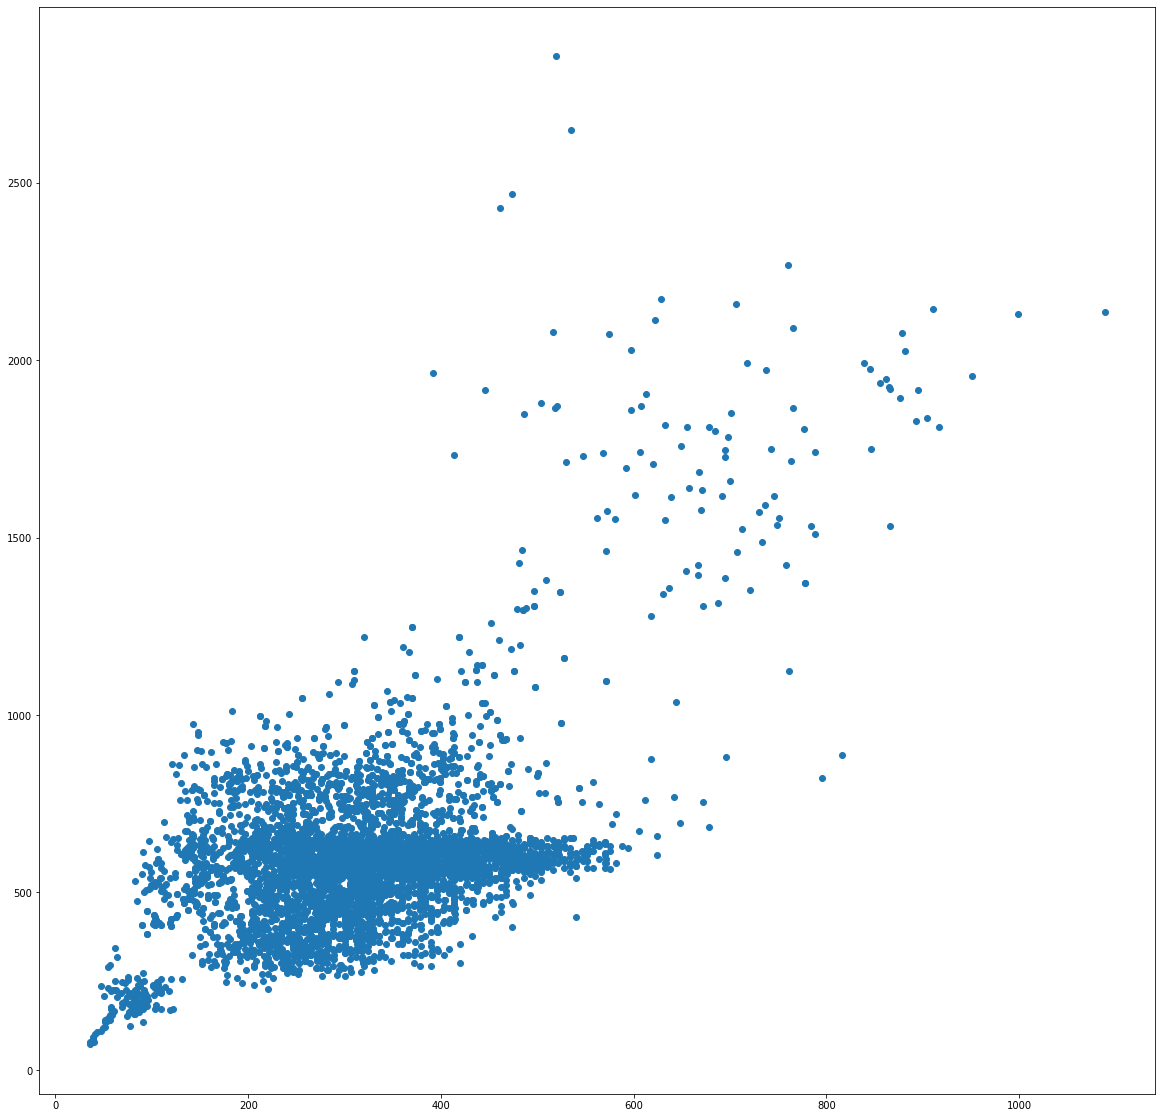

In [ ]:
import matplotlib.pyplot as plt

xs = [x[0] for x in original_shapes]
ys = [x[1] for x in original_shapes]

plt.scatter(xs, ys)
plt.show()

In [ ]:
print("Min dimensions:", min(xs), min(ys))
print("Min dimensions:", max(xs), max(ys))

Min dimensions: 36 72
Min dimensions: 1089 2857


In [ ]:
# 109 utenti hanno tutte le immagini con una dimensione superiore a 128x256
'''
user_high_res = []

for id in original_shapes.keys():
  id_shapes = original_shapes[id]
  high_res = True
  for s in id_shapes:
    if s[0] < 128 or s[1] < 256:
      high_res = False
      break
  if high_res: 
    user_high_res.append(id)

len(user_high_res)
'''

## Image Preprocessing example

Esempio di come vengono preprocessate le immagini

In [ ]:
def img_preprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Greyscale
  #img = cv2.GaussianBlur(img, (5,5), 0) # Gaussian blur
  img[ img > 230 ] = 255
  #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Threshold
  img = cv2.bitwise_not(img) # Invert
  img = cv2.resize(img, (256, 128), interpolation = cv2.INTER_LINEAR) # is (128, 256) not (256, 128)
  return img

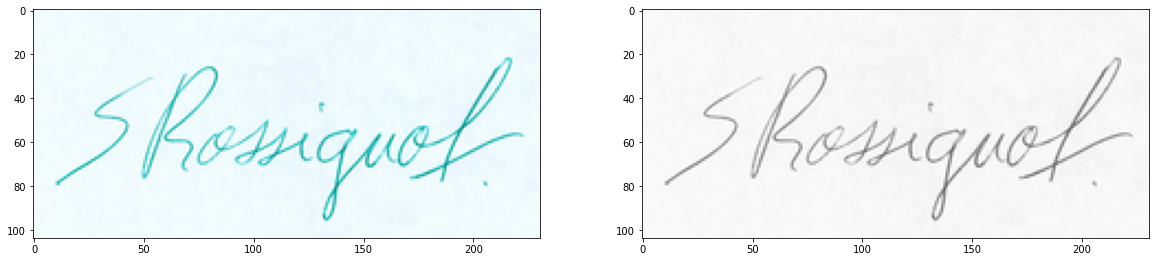

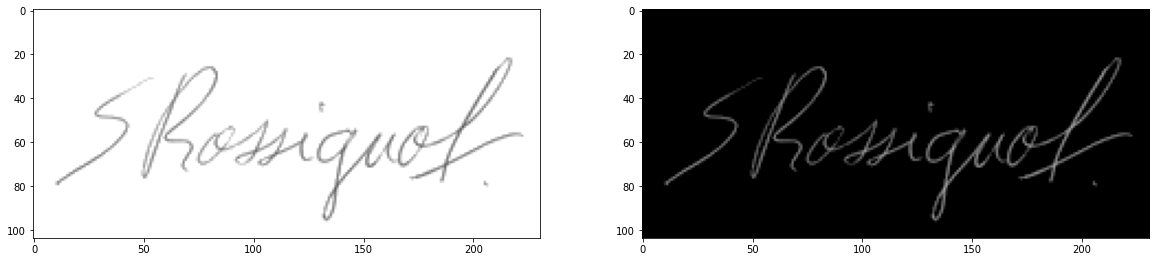

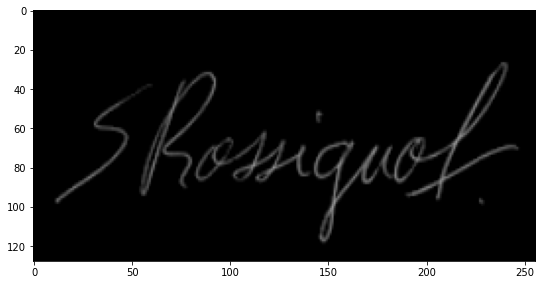

In [ ]:
path = os.path.join(base_dir,"Kaggle","sample_Signature","sample_Signature","genuine","NFI-01605016.png")
img = cv2.imread(path)

plt.rcParams['figure.figsize'] = [20, 20]
_ , axarr = plt.subplots(1,2)

# Original - RGB
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
axarr[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

_ , axarr = plt.subplots(1,2)
# Thresholding binarization
threshold = 230
img[ img > threshold ] = 255
_ = axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Invert
img = cv2.bitwise_not(img)
_ = axarr[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.rcParams['figure.figsize'] = [9, 9]
# Resize
img = cv2.resize(img, (256, 128), interpolation = cv2.INTER_LINEAR)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

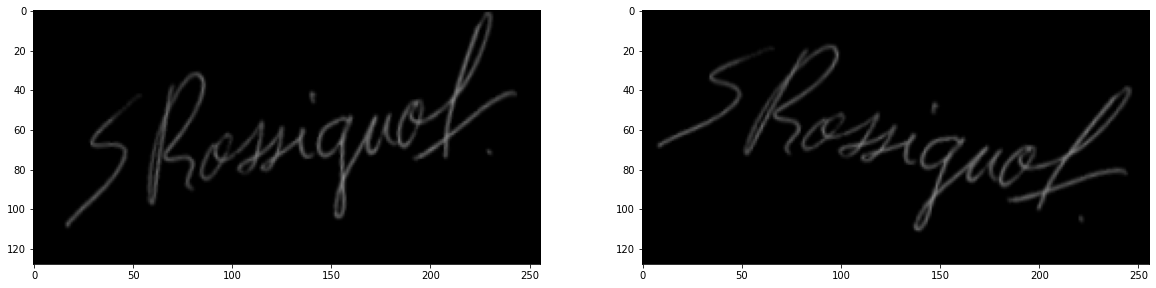

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
_ , axarr = plt.subplots(1,2)
cropped = crop(img)
rotated_1 = padding_reshape(imutils.rotate_bound(cropped, -10))
axarr[0].imshow(cv2.cvtColor(rotated_1, cv2.COLOR_BGR2RGB))

rotated_2 = padding_reshape(imutils.rotate_bound(cropped, 10))
axarr[1].imshow(cv2.cvtColor(rotated_2, cv2.COLOR_BGR2RGB))

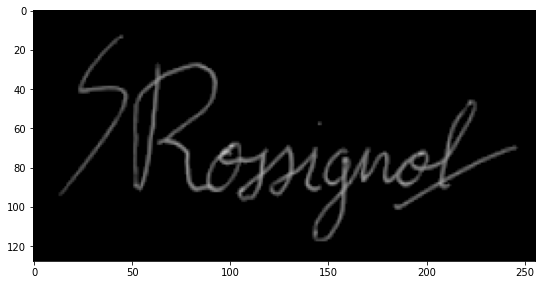

In [ ]:
path = os.path.join(base_dir,"Kaggle","sample_Signature","sample_Signature","forged","NFI-01104016.png")
img = cv2.imread(path)



plt.rcParams['figure.figsize'] = [9, 9]
# Resize
img = cv2.resize(img, (256, 128), interpolation = cv2.INTER_LINEAR)
plt.figure()
plt.imshow(cv2.cvtColor(img_preprocess(img), cv2.COLOR_BGR2RGB))

# Note

La threshold di Otsu riduce l'accuratezza del modello rispetto a quella fissa a 230, taglia alcune parti della firma. Però in alcune immagini taglia meglio lo sfondo. Non vorrei che la rete impari a riconoscere gli artefatti nello sfondo..
